In [1]:
%matplotlib inline
######################################################################################################
#
#         SCRIPT DESCRIPTION: Basic Q-Learning in a single intersection
#
#         Input: Map name, route file
#         Output: Tripinfo.xml
#
#####################################################################################################

# Set OPERATING SYSTEM
OS = "iOS"
# Set MAP and time
used_map = 'cross_straight_random'
simulation_length = 360000
# Select whether to use previous experience
reloadQm  = True
saveQm    = True
# Set Path for Sumo Home folder
if OS == "iOS":
    sumo_home_dir = "/Users/acabrejasegea/sumo-0.32/"
elif OS == "windows":
    sumo_home_dir = "C:\Program Files (x86)\DLR\Sumo"
else:
    sys.exit("Please declare a supported operative system")

# Import basic libraries
import os
import sys
import optparse
import subprocess
import random
import random
import pdb
import xmltodict
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from __future__ import absolute_import
from __future__ import print_function

# Current working directory
working_dir = os.getcwd()

# Set environment variable SUMO_HOME
try:
    # Use this line only to manually define SUMO_HOME path
    os.environ["SUMO_HOME"] = sumo_home_dir
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
except ImportError:
    sys.exit(
        "Please declare environment variable 'SUMO_HOME' as the root directory of your sumo installation (it should contain folders 'bin', 'tools' and 'docs')")

# Import API libraries
from sumolib import checkBinary
import traci

In [2]:
%%bash
echo $SUMO_HOME

/Users/acabrejasegea/sumo-0.32/


In [3]:
%%javascript
IPython.notebook.kernel.execute('notebook_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [4]:
# Set important directories
if OS=="iOS":
    networks_dir = "/Users/acabrejasegea/sumo-0.32/Data/Networks/"
    scripts_dir = "/Users/acabrejasegea/sumo-0.32/tools/"
    runners_dir = "/Users/acabrejasegea/Desktop/ATI_Project/MLforFlowOptimisation/"
elif OS=="windows":
    networks_dir = "C:\\Program Files (x86)\\DLR\\Sumo\\data\\Networks\\"
    scripts_dir = "C:\\Program Files (x86)\\DLR\\Sumo\\tools\\"
    runners_dir = "C:\\Users\\CabrejasEgeaAlvaro\\Desktop\\ATI\\05_ML_Traffic_Lights\\MLforFlowOptimisation\\"
else:
    sys.exit("Please declare a supported operative system")
notebook = (os.path.splitext(notebook_name))[0]

In [5]:
def keywithmaxval(d):                   #Function used in Example control algorithm
     """ a) create a list of the dict's keys and values; 
         b) return the key with the max value"""  
     v=list(d.values())
     k=list(d.keys())
     return k[v.index(max(v))]

def getEdgeData(edgeIDs):
    #Edge data order (type: double / integer): [CO2, CO, Hydrocarbons, NOx, PMx, Noise,
    #mean Vehicle Length, mean Speed,occupancy, number of vehicles (integer),
    #estimated travel time, Waiting time]
    #http://sumo.dlr.de/daily/pydoc/traci._edge.html 
    data = []

    for i in range(0,len(edgeIDs)):
        data.append(traci.edge.getCO2Emission(edgeIDs[i]))
        data.append(traci.edge.getCOEmission(edgeIDs[i]))
        data.append(traci.edge.getHCEmission(edgeIDs[i]))
        data.append(traci.edge.getNOxEmission(edgeIDs[i]))
        data.append(traci.edge.getPMxEmission(edgeIDs[i]))
        data.append(traci.edge.getNoiseEmission(edgeIDs[i]))
        data.append(traci.edge.getLastStepLength(edgeIDs[i]))
        data.append(traci.edge.getLastStepMeanSpeed(edgeIDs[i]))
        data.append(traci.edge.getLastStepOccupancy(edgeIDs[i]))
        data.append(traci.edge.getLastStepVehicleNumber(edgeIDs[i]))
        data.append(traci.edge.getTraveltime(edgeIDs[i]))
        data.append(traci.edge.getWaitingTime(edgeIDs[i]))
    return data

def getInductionLoopData(inductionLoopIDs):
    #Inductive Loop data order (type: double / integer): [mean Vehicle Length,
    #mean Speed, occupancy, number of vehicles (integer)]
    #http://sumo.dlr.de/daily/pydoc/traci._inductionloop.html 
    data = []

    for i in range(0,len(inductionLoopIDs)):
        data.append(traci.inductionloop.getLastStepLength(inductionLoopIDs[i]))
        data.append(traci.inductionloop.getLastStepMeanSpeed(inductionLoopIDs[i]))
        data.append(traci.inductionloop.getLastStepOccupancy(inductionLoopIDs[i]))
        data.append(traci.inductionloop.getLastStepVehicleNumber(inductionLoopIDs[i]))
    return data

def getLaneData(laneIDs):
    #Lane data order (type: double / integer): [CO2, CO, Hydrocarbons, NOx, PMx, Noise,
    #mean Vehicle Length, mean Speed, occupancy, number of vehicles (integer),
    #estimated travel time, Waiting time]
    #http://sumo.dlr.de/daily/pydoc/traci._lane.html 
    data = []

    for i in range(0,len(laneIDs)):
        data.append(traci.lane.getCO2Emission(laneIDs[i]))
        data.append(traci.lane.getCOEmission(laneIDs[i]))
        data.append(traci.lane.getHCEmission(laneIDs[i]))
        data.append(traci.lane.getNOxEmission(laneIDs[i]))
        data.append(traci.lane.getPMxEmission(laneIDs[i]))
        data.append(traci.lane.getNoiseEmission(laneIDs[i]))
        data.append(traci.lane.getLastStepLength(laneIDs[i]))
        data.append(traci.lane.getLastStepMeanSpeed(laneIDs[i]))
        data.append(traci.lane.getLastStepOccupancy(laneIDs[i]))
        data.append(traci.lane.getLastStepVehicleNumber(laneIDs[i]))
        data.append(traci.lane.getTraveltime(laneIDs[i]))
        data.append(traci.lane.getWaitingTime(laneIDs[i]))
    return data

def getLaneAreaData(laneAreaIDs):
    #Lane area characteristic order (type: double / integer): [jam length (m), jam length (no. vehicles),
    #mean Speed, occupancy, number of vehicles (integer)]
    #http://sumo.dlr.de/daily/pydoc/traci._lanearea.html 
    data = []
    
    for i in range(0,len(laneAreaIDs)):
        data.append(traci.lanearea.getJamLengthMeters(laneAreaIDs[i]))
        data.append(traci.lanearea.getJamLengthVehicle(laneAreaIDs[i]))
        data.append(traci.lanearea.getLastStepMeanSpeed(laneAreaIDs[i]))
        data.append(traci.lanearea.getLastStepOccupancy(laneAreaIDs[i]))
        data.append(traci.lanearea.getLastStepVehicleNumber(laneAreaIDs[i]))
    return data

def getMultiEntryExitData(multiEntryExitIDs):
    #Multi entry exit detection area data order (type: double / integer):
    #mean Speed, number of vehicles (integer)]
    #http://sumo.dlr.de/daily/pydoc/traci._multientryexit.html 
    data = []

    for i in range(0,len(multiEntryExitIDs)):
        data.append(traci.multientryexit.getLastStepMeanSpeed(multiEntryExitIDs[i]))
        data.append(traci.multientryexit.getLastStepVehicleNumber(multiEntryExitIDs[i]))
    return data

def getSimulationData():
    #Simulation data order (type: double):
    #[current time, number of vehicles entering the network]
    #http://sumo.dlr.de/daily/pydoc/traci._simulation.html
    data = []

    data.append(traci.simulation.getCurrentTime())
    data.append(traci.simulation.getDepartedNumber())
    return data

def getTrafficLightData(trafficLightIDs):
    #Traffic light data = [current phase ID, phase duration,
    #current traffic phase]
    #http://sumo.dlr.de/daily/pydoc/traci._trafficlights.html 
    data = []

    for i in range(0,len(trafficLightIDs)):
        data.append(traci.trafficlights.getPhase(trafficLightIDs[i]))
        data.append(traci.trafficlights.getPhaseDuration(trafficLightIDs[i])) #this will reference the fixed time
        data.append(traci.trafficlights.getRedYellowGreenState(trafficLightIDs[i]))
    return data

def getVehicleData(vehicleIDs):
    #Individual vehicle data = [CO2, CO, Hydrocarbons, NOx, PMx, Noise,
    #emission class, total distance travelled (odometer), length,
    #list of upcoming traffic lights [(tlsID, tlsIndex, distance, state), ...], position (m,m),
    #vehicle route (edge IDs),current Speed, Vehicle Class, Waiting Time (below 0.1m/s)]
    #http://sumo.dlr.de/daily/pydoc/traci._vehicle.html 
    data = []

    for i in range(0,len(vehicleIDs)):
        data.append(traci.vehicle.getCO2Emission(vehicleIDs[i]))
        data.append(traci.vehicle.getCOEmission(vehicleIDs[i]))
        data.append(traci.vehicle.getHCEmission(vehicleIDs[i]))
        data.append(traci.vehicle.getNOxEmission(vehicleIDs[i]))
        data.append(traci.vehicle.getPMxEmission(vehicleIDs[i]))
        data.append(traci.vehicle.getNoiseEmission(vehicleIDs[i]))
        data.append(traci.vehicle.getEmissionClass(vehicleIDs[i]))
        data.append(traci.vehicle.getDistance(vehicleIDs[i]))
        data.append(traci.vehicle.getLength(vehicleIDs[i]))
        data.append(traci.vehicle.getNextTLS(vehicleIDs[i]))
        data.append(traci.vehicle.getPosition(vehicleIDs[i]))
        data.append(traci.vehicle.getRoute(vehicleIDs[i]))
        data.append(traci.vehicle.getSpeed(vehicleIDs[i]))
        data.append(traci.vehicle.getVehicleClass(vehicleIDs[i]))
        data.append(traci.vehicle.getWaitingTime(vehicleIDs[i]))
    return data

def getStaticLaneData(laneIDs):
    #Static lane data = [Lane Length, Max Speed]
    #http://sumo.dlr.de/daily/pydoc/traci._lane.html
    data = []

    #Get lane characteristics
    for i in range(0,len(laneIDs)):
        data.append(traci.lane.getLength(laneIDs[i]))
        data.append(traci.lane.getMaxSpeed(laneIDs[i]))
    return data

def getStaticTrafficLightData(trafficLightIDs):
    #Static traffic light data = [lanes controlled by traffic lights, links controlled
    #by traffic lights, ]
    #http://sumo.dlr.de/daily/pydoc/traci._trafficlights.html 
    data = []

    for i in range(0,len(trafficLightIDs)):
        data.append(traci.trafficlight.getControlledLanes(trafficLightIDs[i]))
        data.append(traci.trafficlight.getControlledLinks(trafficLightIDs[i]))
    return data

In [6]:
# Creates a route file for the simulation
def generate_routefile(simulation_length):
    random.seed(42)  # make tests reproducible
    # demand per second from different directions
    pWE = 1. / 3
    pEW = 1. / 3
    pNS = 1. / 6
    pSN = 1. / 6
    
    # Algorithmic access to routefile (names need to be consistent)
    with open(os.path.join(networks_dir, used_map, (used_map + '.rou.xml')), "w") as routes:
        print("""<routes>
        <vType id="typeWE" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2" maxSpeed="25" guiShape="passenger"/>
        <vType id="typeNS" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2" maxSpeed="25" guiShape="passenger"/>

        <route id="right" edges="iW oE" />
        <route id="left" edges="iE oW" />
        <route id="down" edges="iN oS" />
        <route id="up" edges="iS oN" />""", file=routes)
        lastVeh = 0
        vehNr = 0
        for i in range(simulation_length):
            if random.uniform(0, 1) < pWE:
                print('    <vehicle id="right_%i" type="typeWE" route="right" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
                lastVeh = i
            if random.uniform(0, 1) < pEW:
                print('    <vehicle id="left_%i" type="typeWE" route="left" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
                lastVeh = i
            if random.uniform(0, 1) < pNS:
                print('    <vehicle id="down_%i" type="typeNS" route="down" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
                lastVeh = i
            if random.uniform(0, 1) < pSN:
                print('    <vehicle id="down_%i" type="typeNS" route="up" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
                lastVeh = i
        print("</routes>", file=routes)

In [7]:
class NetworkParser:

    def __init__(self, file_path):
        self.junctions = dict()
        self.junction_lights = dict()

        with open(file_path) as f:
            self.file = xmltodict.parse(f.read())

    def get_lane_ids(self):
        for junction in self.file['net']['junction']:
            if junction['@type'] == 'traffic_light':
                self.junctions[junction['@id']] = junction['@incLanes'].split(' ')
        return self.junctions

    # Given a LaneID it returns the traffic light ID
    def get_trafficlights_by_laneID(self, laneID):
        for connection in self.file['net']['connection']:
            if connection['@from'] == laneID.split('_')[0] and '@tl' in connection:
                return connection['@tl']

    def get_junction_trafficlights(self):
        # If the dictionarty for junctions is empty
        if not self.junctions:
            self.get_lane_ids()
        for junctionID in self.junctions.keys():
            for lane in self.junctions[junctionID]:
                traffic_light = self.get_trafficlights_by_laneID(lane)
                if traffic_light in self.junction_lights and lane not in self.junction_lights[traffic_light]:
                    self.junction_lights[traffic_light].append(lane)
                else:
                    self.junction_lights[traffic_light] = []
        return self.junction_lights

    def get_traffic_light(self, laneID):
        if not self.junction_lights:
            self.get_junction_trafficlights()
        for traffic_light, lanes in self.junction_lights.iteritems():
            if laneID in lanes:
                return traffic_light

    def get_phases(self, traffic_light):
        phases = []
        z = 0
        for tls in self.file['net']['tlLogic']:
            if z < 1:
                a=0
            z+=1
            if tls['@id'] == traffic_light:
                for tls_phase in tls['phase']:
                    phases.append(tls_phase)
        return phases

In [8]:
class Qlearner:
    def __init__(self,TLid,lanes,phases):
        self.jid     = TLid
        self.TLid    = TLid
        self.laneids = lanes
        self.Nlanes  = len(self.laneids)                                #len(nodes.junctions[self.jid])
        self.phases  = range(0, 23)                            #traci.trafficlights.getallPhases
        num_phases   = len(self.phases)
        self.Qm      = np.zeros((25, 11))
        
        self.state   = 0
        self.action  = 0
                                
        self.cycle_time = 90
        
        self.historic_reward = list()
  
    def set_action(self,action):                               
        traci.trafficlights.setProgram(self.jid, str(action))
                                                                

    def get_reward(self):
        # Reward defined as a measure of the amount of waiting in the intersection
        return -sum([traci.lane.getLastStepHaltingNumber(lane_id) for lane_id in self.laneids])
 

    def get_state(self,threshold_l=3):
        # State is defined as a combination b/w 5 load level for the 2 routes
        NS_occupancy = traci.lane.getLastStepHaltingNumber("iN_0") + traci.lane.getLastStepHaltingNumber("iS_0")
        EW_occupancy = traci.lane.getLastStepHaltingNumber("iE_0") + traci.lane.getLastStepHaltingNumber("iW_0")

        NS_state = np.trunc(NS_occupancy/10)
        EW_state = np.trunc(EW_occupancy/10)
        
        if NS_state > 4:
            NS_state = 4
        if EW_state >4:
            EW_state = 4
        
        state = int(NS_state + 5* EW_state)

        return(state)

    def update(self,gamma=0.8,alpha=0.95,epsilon=0.025):
        
        # Get current state, action from class
        state    = self.state
        action   = self.action
        # Generate new action and the reward
        newstate = self.get_state()
        reward   = self.get_reward()
        self.historic_reward.append(reward)

        # Update the Q matrix
        self.Qm[state, action] = self.Qm[state, action]*(1-alpha) + alpha*(reward + gamma*np.max(self.Qm[newstate,:]))

        # Explore or exploit
        r=np.random.rand(1)
        if r > epsilon :
            newaction = np.argmax(self.Qm[state,:])
        else:
            newaction = np.random.randint(0, 10)
    
        # Set variables for next loop and reset cycle timer
        self.state = newstate
        self.action = newaction
                                
        self.set_action(newaction)

In [9]:
def run(learners = []):
    cycle_timer = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        if cycle_timer == 90:
            for learner in learners:
                learner.update()
            cycle_timer = 0
        else:
            cycle_timer = cycle_timer + 1
    
    sys.stdout.flush()

### ORIGINAL SIMPLE CONTROLLER BELOW ###
# The program looks like this
#    <tlLogic id="0" type="static" programID="0" offset="0">
# the locations of the tls are      NESW
#        <phase duration="31" state="GrGr"/>
#        <phase duration="6"  state="yryr"/>
#        <phase duration="31" state="rGrG"/>
#        <phase duration="6"  state="ryry"/>
#    </tlLogic>
#
#def run():
#    """execute the TraCI control loop"""
#    step = 0
#    # we start with phase 2 where EW has green
#    traci.trafficlight.setPhase("0", 2)
#    while traci.simulation.getMinExpectedNumber() > 0:
#        traci.simulationStep()
#        if traci.trafficlight.getPhase("0") == 2:
#            # we are not already switching
#            if traci.inductionloop.getLastStepVehicleNumber("0") > 0:
#                # there is a vehicle from the north, switch
#                traci.trafficlight.setPhase("0", 3)
#            else:
#                # otherwise try to keep green for EW
#                traci.trafficlight.setPhase("0", 2)
#        step += 1
#    traci.close()
#    sys.stdout.flush()

In [10]:
def get_options():
    optParser = optparse.OptionParser()
    optParser.add_option("--nogui", action="store_true",
                         default=False, help="run the commandline version of sumo")
    options, args = optParser.parse_args()
    return options

In [11]:
# Deployment of Network Parser (input is network file)
npa = NetworkParser(os.path.join(networks_dir, used_map, (used_map + '.net.xml')))

In [12]:
nodes = npa.junctions
phase_list = [len(npa.get_phases(k)) for k in npa.get_junction_trafficlights().keys()]

In [13]:
# Checks
print(nodes)
print(nodes.keys())
print(phase_list)

{'gneJ1': ['iN_0', 'iE_0', 'iS_0', 'iW_0']}
dict_keys(['gneJ1'])
[44]


In [14]:
generate_routefile(simulation_length)

In [15]:
sumoBinary = checkBinary('sumo-gui')
# OR
# sumoBinary = checkBinary('sumo')

In [16]:
learners=[Qlearner(ID,lan,p) for ID, lan, p in zip(nodes.keys(),nodes.values(),phase_list)]

In [17]:
if reloadQm == True:
    learners[0].Qm = np.load(networks_dir+used_map+"/"+"Qm" + str(0) + ".npy")
    print("Loaded pre-trained Q-matrix from file: "+networks_dir+used_map+"/"+"Qm" + str(0) + ".npy")
    with open(networks_dir+used_map+"/"+"Reward" + str(0), 'rb') as fp:
         learners[0].historic_reward = pickle.load(fp)
    print("Loaded corresponding Reward history to file: "+networks_dir+used_map+"/"+"Reward" + str(0) + ".npy")

Loaded pre-trained Q-matrix from file: /Users/acabrejasegea/sumo-0.32/Data/Networks/cross_straight_random/Qm0.npy
Loaded corresponding Reward history to file: /Users/acabrejasegea/sumo-0.32/Data/Networks/cross_straight_random/Reward0.npy


In [18]:
traci.start([sumoBinary, "-c", os.path.join(networks_dir, used_map, (used_map + '.sumocfg')),
                             "--tripinfo-output", os.path.join((notebook + '_out'), 'tripinfo.xml')])

Could not connect to TraCI server at localhost:49550 [Errno 61] Connection refused
 Retrying in 1 seconds
Could not connect to TraCI server at localhost:49550 [Errno 61] Connection refused
 Retrying in 2 seconds
Could not connect to TraCI server at localhost:49550 [Errno 61] Connection refused
 Retrying in 3 seconds


(17, 'SUMO 0.32.0')

In [19]:
run(learners)

FatalTraCIError: connection closed by SUMO

In [ ]:
if saveQm == True:
    np.save(networks_dir+used_map+"/"+"Qm" + str(0) + ".npy", learners[0].Qm)
    print("Saved Q-matrix to file: "+networks_dir+used_map+"/"+"Qm" + str(0) + ".npy")
    reward_file = open(networks_dir+used_map+"/"+"Reward" + str(0) + ".txt", 'w')
    with open(networks_dir+used_map+"/"+"Reward" + str(0), 'wb') as fp:
        pickle.dump(learners[0].historic_reward, fp)
    print("Saved Reward history to file: "+networks_dir+used_map+"/"+"Reward" + str(0))

In [20]:
learners[0].Qm

array([[ -61.94261811,  -59.75433574,  -61.57011252,  -87.35454532,
         -60.19610718,  -76.36647399,  -65.47813369,  -90.72876382,
         -98.90503818, -115.29703391,  -90.95815203],
       [ -88.34643616,  -95.62523558,  -98.03527346,  -90.29433199,
         -76.09193025,  -92.20003408,  -73.71958212,  -95.66671958,
         -93.86006795, -103.70855407, -105.13922076],
       [-116.73413523, -100.39926687,  -83.55250445,  -87.15814405,
         -80.98704225,  -91.66459088, -100.29183246,  -79.18178662,
         -93.52687046, -102.77520138, -100.11148847],
       [-131.31243679, -103.9939184 ,  -90.92873542,  -84.25472865,
         -95.74422156,  -81.47365866,  -80.55154746,  -87.55999868,
         -88.46587411,  -97.92280422, -112.15095005],
       [-120.44189844, -141.22462799, -120.00229951,  -95.97986605,
         -91.12872103,  -92.39468308,  -93.12734537,  -51.44712211,
         -94.0813287 ,  -72.64117617,  -88.94518445],
       [-110.67580703,  -80.05225393,  -84.3216825

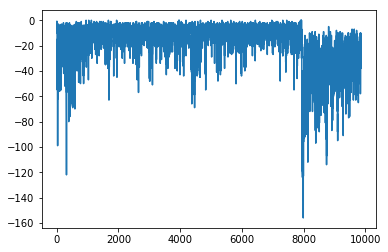

In [21]:
plt.plot(learners[0].historic_reward)
plt.show()

In [ ]:
nodes